# **Using Tensorflow for detecting Covid-19 Infected Lungs from Normal Lungs with Chest X-Ray**
**Dataset** - Radioraphy with 3616 covid xray images and over 10,000 normal lungs images. We picked 3616 normal images to eliminate bias

**Preprocessing:** Images were augumented with Rescaling, Featurewise_center, Featurewise_std_normalization, Rotation_range, Width_shift_range, Height_shift_range, Zoom_range, Brightness_range ,Validation_split

# **The CNN architecture was as follows:**
# 1- preprocessing layer

# 2- First_block
conv layer, LeakyReLU, maxpooling 

# 3- Second_block
conv layer, LeakyReLU, maxpooling 

# 4- Third_block
conv layer, LeakyReLU

# 5-Forth_block
conv layer, LeakyReLU, maxpooling 

# 6- Flatten and Fully Connected Layer
flatten, dense, LekyReLU

# 7- Softmax Classifier
dense with softmax activation

# 
**Trained** on 100 epochs. After 81th epoch, model started to overfit

**Accuracy** on validation set was 96.08%

In [4]:
from keras.models import Sequential,load_model
from keras.layers import LeakyReLU,Conv2D,Activation, MaxPooling2D,Dense,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
# from PIL import Image
import seaborn as sns
import numpy as np
from keras.callbacks import EarlyStopping
# import pathlib
from pathlib import Path
import tensorflow as tf
BASE_DIR = Path().resolve().parent
tmp = BASE_DIR / "tmp"
tmp.mkdir(exist_ok= True,parents=True)
Xray_train_data = tmp / "Xray_train_data"
Xray_train_data.mkdir(exist_ok= True,parents=True)
Xray_test_data = Xray_train_data / "Test"
Xray_test_data.mkdir(exist_ok= True,parents=True)
Xray_train_data

WindowsPath('C:/Users/test/OneDrive/Desktop/CovidWithTensorFlow/tmp/Xray_train_data')

# -------------------------------------------------------------------------
#                        **Build CNN Model** 
# -------------------------------------------------------------------------

In [5]:
def Build_CNN_Model():
    
    
    model = Sequential()
    
    #  First Block of CNN
    model.add(Conv2D(8, (5, 5), padding='same', input_shape=(256, 256, 3)))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    #  Second Block of CNN
    model.add(Conv2D(8, (3, 3),  padding='same'))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    #  Third Block of CNN
    model.add(Conv2D(16, (3, 3),  padding='same'))  
    model.add(LeakyReLU(alpha=0.1))


    #  Forth Block of CNN
    model.add(Conv2D(16, (3, 3),  padding='same'))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    
    #  Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(10))
    model.add(LeakyReLU(alpha=0.1))
     
    #  Softmax Classifier
    model.add(Dense(2))
    model.add(Activation('softmax'))
        
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 

# -------------------------------------------------------------------------
#                        **Train CNN Model** 
# -------------------------------------------------------------------------

In [21]:
# train and evalluate cnn model
def Train_CNN_Model(model):
    

    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     validation_split=0.3
                                     )
  
   
    # prepare iterators
    batch_size=32
    IMAGE_SIZE = (256, 256)
    img_height, img_width= IMAGE_SIZE
    
    train_it = train_datagen.flow_from_directory(
        Xray_train_data,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        # class_mode='binary',
        classes =('covid','normal'),
        subset='training') # set as training data
        
    # Splitting images for validation set
    valid_it = train_datagen.flow_from_directory(
        Xray_train_data, # same directory as training data
        target_size=(img_height, img_width),
        batch_size=batch_size,
        # class_mode='binary',
        classes =('covid','normal'),
        subset='validation') # set as validation data


    epochs=100

    # Early stopping
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
    
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),validation_data=valid_it, 
                                  validation_steps=len(valid_it), epochs=epochs,callbacks=[es], verbose=1 ,workers = 10 )
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model_2.h5')
    import tensorflow as tf
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("medical_diagnosis_cnn_model_2.tflite", 'wb') as f:
        f.write(tflite_model)

# -------------------------------------------------------------------------
#                        **Evaluate CNN Model** 
# -------------------------------------------------------------------------

In [15]:
def Evaluate_CNN_Model():

    
    # load model
    model = load_model('medical_diagnosis_cnn_model_2.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     validation_split=0.2)
    
    test_it = test_datagen.flow_from_directory(Xray_train_data,classes =('covid','normal'), 
                                               shuffle=False,batch_size=batch_size, target_size=(256, 256),subset='validation')
    
    y_true = test_it.classes

    y_pred = model.predict(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary))
    
    sns.heatmap(confusion_matrix(y_true,y_pred_binary)/np.sum(confusion_matrix(y_true,y_pred_binary)), annot=True, 
            fmt='.2%', cmap='Blues')
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()
    

    


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       608       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1

D:\Users\test\anaconda3\envs\work_lib\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Users\test\anaconda3\envs\work_lib\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
303/303 [==============================] - 72s 218ms/step - loss: 0.5467 - accuracy: 0.7381 - val_loss: 0.6510 - val_accuracy: 0.7380
Epoch 2/100
303/303 [==============================] - 68s 217ms/step - loss: 0.4916 - accuracy: 0.7635 - val_loss: 0.4365 - val_accuracy: 0.7967
Epoch 3/100
303/303 [==============================] - 67s 215ms/step - loss: 0.4451 - accuracy: 0.7895 - val_loss: 0.4100 - val_accuracy: 0.8242
Epoch 4/100
303/303 [==============================] - 68s 220ms/step - loss: 0.4157 - accuracy: 0.8069 - val_loss: 0.3815 - val_accuracy: 0.8334
Epoch 5/100
303/303 [==============================] - 67s 217ms/step - loss: 0.3838 - accuracy: 0.8309 - val_loss: 0.3722 - val_accuracy: 0.8348
Epoch 6/100
303/303 [==============================] - 68s 220ms/step - loss: 0.3720 - accuracy: 0.8306 - val_loss: 0.3386 - val_accuracy: 0.8573
Epoch 7/100
303/303 [==============================] - 69s 223ms/step - loss: 0.3425 - accuracy: 0.8510 - val_loss: 0.3341 -

Epoch 57/100
303/303 [==============================] - 72s 235ms/step - loss: 0.1466 - accuracy: 0.9433 - val_loss: 0.1507 - val_accuracy: 0.9471
Epoch 58/100
303/303 [==============================] - 74s 235ms/step - loss: 0.1260 - accuracy: 0.9515 - val_loss: 0.1340 - val_accuracy: 0.9503
Epoch 59/100
303/303 [==============================] - 71s 229ms/step - loss: 0.1221 - accuracy: 0.9554 - val_loss: 0.1544 - val_accuracy: 0.9445
Epoch 60/100
303/303 [==============================] - 73s 236ms/step - loss: 0.1235 - accuracy: 0.9507 - val_loss: 0.1591 - val_accuracy: 0.9433
Epoch 61/100
303/303 [==============================] - 72s 232ms/step - loss: 0.1328 - accuracy: 0.9472 - val_loss: 0.1633 - val_accuracy: 0.9399
Epoch 62/100
303/303 [==============================] - 75s 237ms/step - loss: 0.1266 - accuracy: 0.9516 - val_loss: 0.1326 - val_accuracy: 0.9524
Epoch 63/100
303/303 [==============================] - 72s 232ms/step - loss: 0.1254 - accuracy: 0.9523 - val_loss: 0

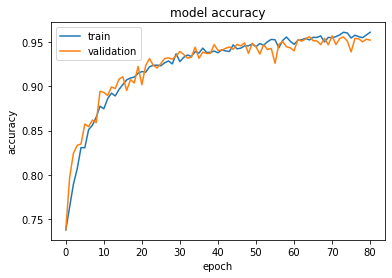

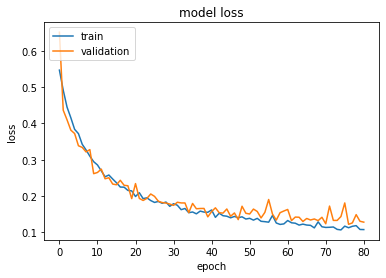

INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmpfog2ca39\assets


In [5]:
# main entry
    
model = Build_CNN_Model()

Train_CNN_Model(model)
    


Found 2761 images belonging to 2 classes.


d:\Users\test\anaconda3\envs\work_lib\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\Users\test\anaconda3\envs\work_lib\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


87/87 [==============================] - 8s 94ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Confusion Matrix
 -------------------------
[[ 597  126]
 [  18 2020]]
Accuracy: 0.947845
Precision: 0.941286
Recall: 0.991168
F1 score: 0.965583
ROC AUC: 0.990266


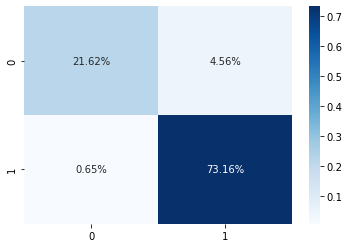

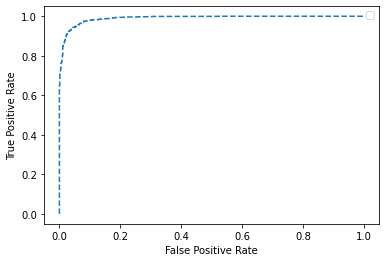

In [16]:
Evaluate_CNN_Model()

In [7]:
model = load_model('medical_diagnosis_cnn_model.h5')
single=Xray_test_data / "single"
single
test_datagen = ImageDataGenerator(   rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
test_it = test_datagen.flow_from_directory(Xray_test_data,classes =('normal','covid'), 
                                               shuffle=False, target_size=(256, 256))
probabilities = model.predict_generator(test_it)
probabilities

Found 1542 images belonging to 2 classes.


C:\Users\test\AppData\Local\Temp/ipykernel_18984/2068265566.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probabilities = model.predict_generator(test_it)
c:\Users\test\AppData\Local\Programs\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\test\AppData\Local\Programs\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


array([[9.99999881e-01, 1.33947083e-07],
       [9.99977827e-01, 2.21213431e-05],
       [9.99891877e-01, 1.08165135e-04],
       ...,
       [6.51365936e-01, 3.48634034e-01],
       [3.63937899e-04, 9.99636054e-01],
       [2.86898599e-03, 9.97130990e-01]], dtype=float32)

In [8]:
y_pred = probabilities > 0.5 
classit = [['covid' for x in y_pred if x[0]== True] ,['normal' for x in y_pred if x[0]==False]]
classit 
class_names = ['covid', 'normal']

In [9]:
classit

[['covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',
  'covid',

In [4]:
Build_CNN_Model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       608       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       584       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                    